Machine Learning - Exercise 02 - Decision Tree

Sinh viên: Nguyễn Hoàng Lộc

MSSV: 1511849

# Setup Enviroment

In [0]:
!apt install -y graphviz

In [0]:
!pip install graphviz

In [0]:
!apt-get install python-pydot

In [0]:
import numpy as np
import pandas as pd
import pprint
from copy import deepcopy as clone
eps = np.finfo(float).eps
from numpy import log2 
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
#import graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
#import pydotplus
from graphviz import *

# Data Preparation

In [0]:
dataset = { 'Alternate'    :['T','T','F','T','T','F','F','F','F','T','F','T'],
            'Bar'          :['F','F','T','F','F','T','T','F','T','T','F','T'],
            'Friday'       :['F','F','F','T','T','F','F','F','T','T','F','T'],
            'Hungry'       :['T','T','F','T','F','T','F','T','F','T','F','T'],
            'Patrons'      :['Some','Full','Some','Full','Full','Some','None','Some','Full','Full','None','Full'],
            'Price'        :['$$$','$','$','$','$$$','$$','$','$$','$','$$$','$','$'],
            'Rain'         :['F','F','F','F','F','T','T','T','T','F','F','F'],
            'Reservation'  :['T','F','F','F','T','T','F','T','F','T','F','F'],
            'Type'         :['French','Thai','Burger','Thai','French','Italian','Burger','Thai','Burger','Italian','Thai','Burger'],
            'WaitEstimate' :['0-10','30-60','0-10','10-30','>60','0-10','0-10','0-10','>60,','10-30','0-10','30-60'],
            'Target'       :['T','F','T','T','F','T','F','T','F','F','F','T'],} 
df = pd.DataFrame(dataset,columns= ['Alternate','Bar','Friday','Hungry','Patrons','Price','Rain','Reservation','Type','WaitEstimate','Target'])
X = df[['Alternate','Bar','Friday','Hungry','Patrons','Price','Rain','Reservation','Type','WaitEstimate']]
y = list(df['Target'])
df

,Alternate,Bar,Friday,Hungry,Patrons,Price,Rain,Reservation,Type,WaitEstimate,Target
0,T,F,F,T,Some,$$$,F,T,French,0-10,T
1,T,F,F,T,Full,$,F,F,Thai,30-60,F
2,F,T,F,F,Some,$,F,F,Burger,0-10,T
3,T,F,T,T,Full,$,F,F,Thai,10-30,T
4,T,F,T,F,Full,$$$,F,T,French,>60,F
5,F,T,F,T,Some,$$,T,T,Italian,0-10,T
6,F,T,F,F,None,$,T,F,Burger,0-10,F
7,F,F,F,T,Some,$$,T,T,Thai,0-10,T
8,F,T,T,F,Full,$,T,F,Burger,">60,",F
9,T,T,T,T,Full,$$$,F,T,Italian,10-30,F


# Decision Tree Implementation 

In [0]:
class DecisionTree():
  def __init__(self):
    self.tree = None
    self.graph = None
    self.count = 0
    
  def fit(self, X, y):
    self.train_data = clone(X)
    self.train_data['Target'] = clone(y)
    self.tree = self._build_tree(self.train_data)
    
  def get_entropy(self, data_frame):
    entropy = 0
    target = list(data_frame['Target'])
    labels = set(target)
    length = len(target)
    for label in labels:
        fraction = target.count(label) / length
        entropy += -fraction*log2(fraction)
    return entropy
  
  def get_entropy_of_feature(self, data_frame, feature_name):
    feature_data = data_frame[feature_name].tolist()
    target = data_frame['Target'].tolist()
    labels = set(target)
    zip_data = list(zip(feature_data, target))
    total_entropy = 0
    for value in set(feature_data): #Với mỗi giá trị độc lập trong cột ứng với feature
      filtered_data = [x[1] for x in zip_data if x[0] == value] #List dữ liệu chứa các nhãn của target tương ứng với giá trị value trong column
      entropy = 0
      length = len(filtered_data)
      for label in labels: #Tính entropy cho mỗi label
        fraction = filtered_data.count(label) / (length + eps)
        entropy += -fraction*log2(fraction + eps)
      total_entropy += -entropy * length / len(target) #Cộng dồn vào entropy tổng của feature
    return abs(total_entropy)
               
  def find_feature_with_max_IG(self, data_frame): 
    info_gain = list() #List chứa lần lượt các infomation gain ứng với các feature 
    features = list(data_frame.keys())[:-1] #Lấy tất cả tên cột ngoại trừ cột target từ dataframe
    entropy = self.get_entropy(data_frame)
    for feature in features:
      info_gain.append(entropy - self.get_entropy_of_feature(data_frame, feature))
    return features[np.argmax(info_gain)]
        
  def get_subdata(self, data_frame, feature, value): #Hàm trả về tập dữ diệu con có các instance mà cột 'feature' đều mang giá trị 'value'
    return data_frame[data_frame[feature] == value].reset_index(drop=True)
  
  def _build_tree(self, data_frame, tree = None): #Hàm xây dựng cây
    node = self.find_feature_with_max_IG(data_frame) 
    node_values = list(set(data_frame[node]))
    if tree is None: #Cây xây dựng dựa trên cấu trúc dictionary                   
      tree = dict()
      tree[node] = dict()
    for value in node_values: #Từ node hiện tại hình thành nên các nhánh
      #print("Branch at node: ", node, ' with value: ' , value)
      subdata = self.get_subdata(data_frame, node,value)
      #print(subdata) 
      clValue,counts = np.unique(subdata['Target'],return_counts = True)                               
      if len(counts) == 1:
          tree[node][value] = clValue[0] #Sinh nốt lá                                                    
      else:        
          tree[node][value] = self._build_tree(subdata)  
    return tree
      
  def predict(self, predict_data, tree = None): 
    if self.tree is None:
      print('You must fit model with train data before making prediction')
      return    
    if tree is None:
      tree = self.tree
    for nodes in tree.keys():        
      value = predict_data[nodes]
      tree = tree[nodes][value]
      prediction = 0
      if type(tree) is dict:
          prediction = self.predict(predict_data, tree)
      else:
          prediction = tree
          break;                            
    return prediction
  
  def print(self):
    pprint.pprint(self.tree)
    
  def visit(self, parrent, tree): #Hàm duyệt cây để in ra đồ thị
    if parrent == 'root':
      root_name = str(list(tree.keys())[0])
      self.graph.node(root_name, root_name)
      self.visit( root_name, tree[root_name])
    else:
      for key in tree.keys():
        if type(tree[key]) is dict:
          new_node_name = list(tree[key].keys())[0]
          self.graph.node(new_node_name, new_node_name, shape = 'rect')
          self.graph.edge(parrent, new_node_name, label = key)
          self.visit(new_node_name, tree[key][new_node_name])
          
        else:
          new_node_name = key + str(self.get_count())
          self.graph.node(new_node_name, tree[key])
          self.graph.edge(parrent, new_node_name, label = key)
  
  def visualize(self):
    self.graph = Digraph()
    self.visit('root', self.tree)
    self.graph.render("decision_tree", format="png")
    return self.graph
  
  def get_count(self): #Hàm sinh số để đánh nhãn cho node của graph
    self.count  = self.count + 1
    return self.count
    

# Decision Tree Demo

In [0]:
my_decs_tree = DecisionTree()
my_decs_tree.fit(X,y)  
my_decs_tree.print()

{'Patrons': {'Full': {'Hungry': {'F': 'F',
                                 'T': {'Type': {'Burger': 'T',
                                                'Italian': 'F',
                                                'Thai': {'Friday': {'F': 'F',
                                                                    'T': 'T'}}}}}},
             'None': 'F',
             'Some': 'T'}}


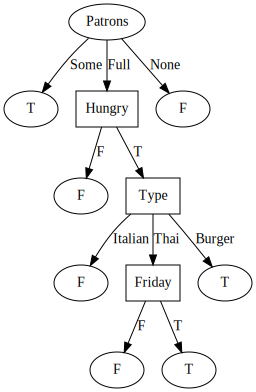

In [0]:
my_decs_tree.visualize()

In [0]:

print('Target:  ',df['Target'].tolist())
pred_list = list()
for i in range(0, 12):
  pred_list.append(my_decs_tree.predict(df.loc[i, : ]))
print('Predict: ',pred_list)

Target:   ['T', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'F', 'F', 'F', 'T']
Predict:  ['T', 'F', 'T', 'T', 'F', 'T', 'F', 'T', 'F', 'F', 'F', 'T']


# Compare with Decision Tree Classifier in sklearn

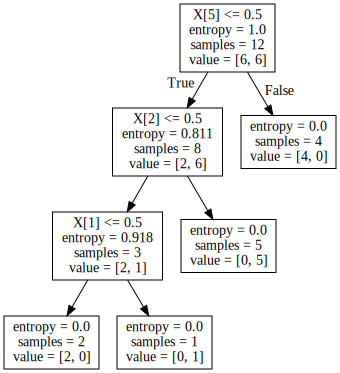

In [0]:
df_float = df.apply(LabelEncoder().fit_transform)
sk_decs_tree = DecisionTreeClassifier(criterion = 'entropy')
sk_decs_tree.fit(df_float.iloc[:,1:], df_float.iloc[:,0])
dot_data = tree.export_graphviz(sk_decs_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph